In [1]:
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD.configuration import Configuration
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import pandas as pd
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.cm as cmx

%matplotlib inline

#import conviction files
from conviction_helpers import *
from conviction_system_logic import *

This notebook uses the differential games framework developed by BlockScience. It is currently in private beta, and building towards a full open source release.

**Description:**

cadCAD is a Python library that assists in the processes of designing, testing and validating complex systems through simulation. At its core, cadCAD is a differential games engine that supports parameter sweeping and Monte Carlo analyses and can be easily integrated with other scientific computing Python modules and data science workflows.

To learn more about cadCAD, follow our [tutorial series](https://github.com/BlockScience/cadCAD-Tutorials/tree/master/01%20Tutorials)

**Installing cadCAD:**

cadCAD is in private beta. Tokens are issued to participants. Replace `<TOKEN>` in the installation URL below
```bash
pip3 install cadCAD --extra-index-url https://<TOKEN>@repo.fury.io/blockscience/
```

If you'd like to participate in the beta program, contact cadcad [at] block [dot] science.


In [2]:
#THIS policy is one of the main paramters of this system!

#maximum share of funds a proposal can take
default_beta = .2 #later we should set this to be param so we can sweep it
# tuning param for the trigger function
default_rho = default_beta**2

def trigger_threshold(requested, funds, supply, beta=default_beta , rho=default_rho):
    
    share = requested/funds
    if share < beta:
        return rho*supply/(beta-share)**2
    else: 
        return np.inf

In [3]:
dict1 = trigger_sweep('token_supply',trigger_threshold)

/Users/Zargham/Documents/GitHub/conviction/conviction_helpers.py:96: RuntimeWarning: divide by zero encountered in log10
  demo_data_Z0[sof_ind,ts_ind] = np.log10(trigger)
/Users/Zargham/Documents/GitHub/conviction/conviction_helpers.py:98: RuntimeWarning: invalid value encountered in double_scalars
  demo_data_Z2[sof_ind,ts_ind] = trigger/tc #share of maximum possible conviction
/Users/Zargham/Documents/GitHub/conviction/conviction_helpers.py:99: RuntimeWarning: invalid value encountered in double_scalars
  demo_data_Z3[sof_ind,ts_ind] = np.log10(trigger/tc)


Text(0.15940000000000001, 1008990000.0, 'fixed alpha = 0.5')

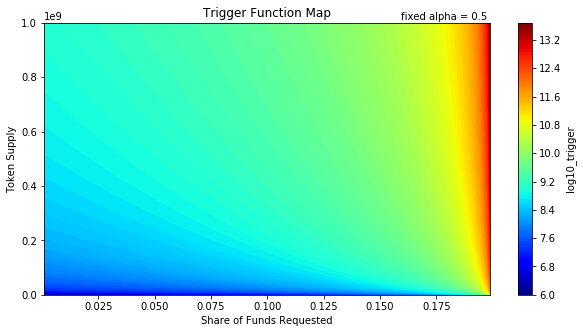

In [4]:
trigger_plotter(dict1['share_of_funds'],
                dict1['log10_trigger'], 
                'log10_trigger',
                dict1['total_supply'],
                'Token Supply')
axis = plt.axis()
plt.text(.2*axis[0]+.8*axis[1],axis[-1]*1.01, 'fixed alpha = 0.5')

In [5]:
dict2 = trigger_sweep('alpha',trigger_threshold)

In [6]:
dict2.keys()

dict_keys(['log10_trigger', 'trigger', 'share_of_max_conv', 'log10_share_of_max_conv', 'alpha', 'share_of_funds'])

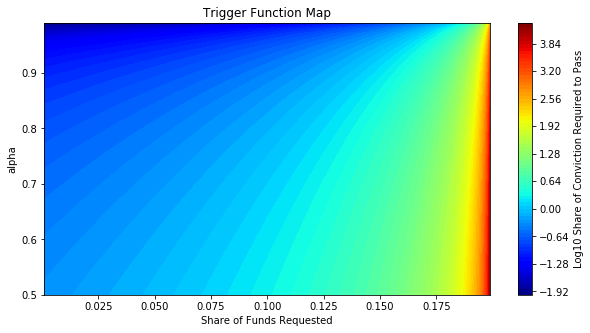

In [7]:
trigger_plotter(dict2['share_of_funds'],
                dict2['log10_share_of_max_conv'], 
                'Log10 Share of Conviction Required to Pass',
                dict2['alpha'],
                'alpha')


In [8]:
n= 25 #initial participants
m= 3 #initial proposals

initial_sentiment = .5

network, initial_funds, initial_supply, total_requested = initialize_network(n,m,total_funds_given_total_supply,trigger_threshold)

Note from Kris, consider: substitutibility of proposals st when a substitute passes, affinity for the others goes away; this will make the process more realistic because proposals will end up never passing.

implementation notes:
- create substitutability matrix (proposal x proposal)
- update accounting when thing pass: change affinities and should affect sentiments
- define a new 'type' of proposals for tracking 'dead' ones (no longer candidates = zero tokens in support)


In [9]:
proposals = get_nodes_by_type(network, 'proposal')
participants = get_nodes_by_type(network, 'participant')

In [10]:
#sample proposal
network.nodes[proposals[0]]

{'type': 'proposal',
 'conviction': 0,
 'status': 'candidate',
 'age': 0,
 'funds_requested': 63248.8961832528,
 'trigger': inf}

In [11]:
#sample participant
network.nodes[participants[0]]

{'type': 'participant',
 'holdings': 753.5821088000997,
 'sentiment': 0.20260793282468248}

In [12]:
#sample relationship participant to proposal
network.edges[(participants[0],proposals[0])]

{'affinity': 0.13023927236764288, 'tokens': 0, 'conviction': 0}

Explore the data created in initial conditions!

Text(0.5, 1.0, 'Histogram of Participants Token Holdings')

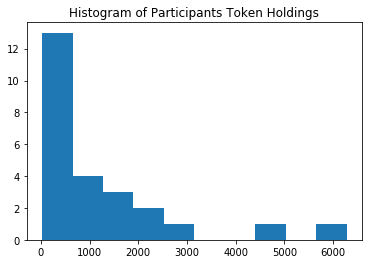

In [13]:
plt.hist([ network.nodes[i]['holdings'] for i in participants])
plt.title('Histogram of Participants Token Holdings')

Text(0.5, 1.0, 'Histogram of Proposals Funds Requested')

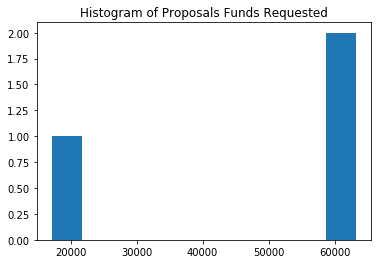

In [14]:
plt.hist([ network.nodes[i]['funds_requested'] for i in proposals])
plt.title('Histogram of Proposals Funds Requested')

Text(0.5, 1.0, 'Histogram of Affinities between Participants and Proposals')

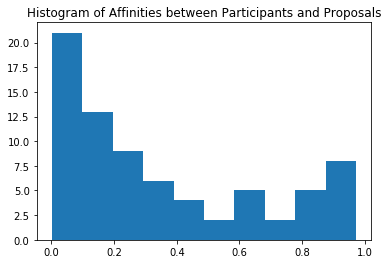

In [15]:
plt.hist([ network.edges[e]['affinity'] for e in network.edges])
plt.title('Histogram of Affinities between Participants and Proposals')

Text(0.5, 1.0, 'Histogram of Affinities between Participants and Proposals weighted by holdings')

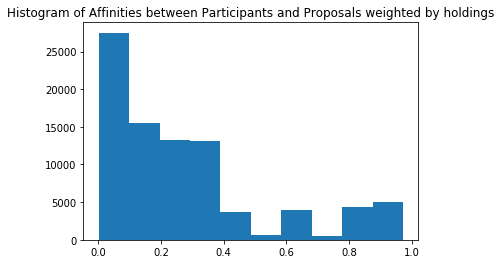

In [16]:
plt.hist([ network.edges[e]['affinity'] for e in network.edges], weights = [network.nodes[e[0]]['holdings']for e in network.edges],alpha = 1)
plt.title('Histogram of Affinities between Participants and Proposals weighted by holdings')

In [17]:
affinities = np.empty((n,m))
for i_ind in range(n):
    for j_ind in range(m):
        i = participants[i_ind]
        j = proposals[j_ind]
        affinities[i_ind][j_ind] = network.edges[(i,j)]['affinity']

Text(0.5, 106.33200000000001, 'participant_id')

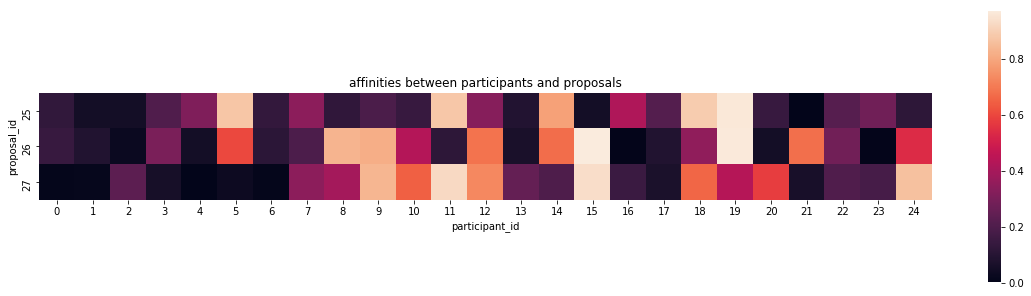

In [18]:
dims = (20, 5)
fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities.T,
            xticklabels=participants,
            yticklabels=proposals,
            square=True,
            cbar=True,
            ax=ax)

plt.title('affinities between participants and proposals')
plt.ylabel('proposal_id')
plt.xlabel('participant_id')

In [19]:
#power of 1 token forever
conviction_capactity = [2]
alpha = [1-1/cc for cc in conviction_capactity]
print(alpha)

[0.5]


In [20]:
params= {
    'sensitivity': [.75],
    'tmin': [7], #unit days; minimum periods passed before a proposal can pass
    'sentiment_decay': [.001], #termed mu in the state update function
    'alpha': alpha,
    'base_completion_rate': [10],
    'trigger_func': [trigger_threshold]
    }

In [28]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
time_periods_per_run = 250
monte_carlo_runs = 1

simulation_parameters = {
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
}

In [29]:
initial_conditions = {'network':network,
                      'supply': initial_supply,
                      'funds':initial_funds,
                      'sentiment': initial_sentiment}

#functions for partial state update block 1

def gen_new_participant(network, new_participant_holdings):
    
    i = len([node for node in network.nodes])
    
    network.add_node(i)
    network.nodes[i]['type']="participant"
    
    s_rv = np.random.rand() 
    network.nodes[i]['sentiment'] = s_rv
    network.nodes[i]['holdings']=new_participant_holdings
    
    for j in get_nodes_by_type(network, 'proposal'):
        network.add_edge(i, j)
        
        rv = np.random.rand()
        a_rv = 1-4*(1-rv)*rv #polarized distribution
        network.edges[(i, j)]['affinity'] = a_rv
        network.edges[(i,j)]['tokens'] = a_rv*network.nodes[i]['holdings']
        network.edges[(i, j)]['conviction'] = 0
    
    return network
    

def gen_new_proposal(network, funds, supply):
    j = len([node for node in network.nodes])
    network.add_node(j)
    network.nodes[j]['type']="proposal"
    
    network.nodes[j]['conviction']=0
    network.nodes[j]['status']='candidate'
    network.nodes[j]['age']=0
    
    rescale = 10000*funds/initial_funds
    r_rv = gamma.rvs(3,loc=0.001, scale=rescale)
    network.node[j]['funds_requested'] = r_rv
    
    network.nodes[j]['trigger']= trigger_threshold(r_rv, funds, supply)
    
    participants = get_nodes_by_type(network, 'participant')
    proposing_participant = np.random.choice(participants)
    
    for i in participants:
        network.add_edge(i, j)
        if i==proposing_participant:
            network.edges[(i, j)]['affinity']=1
        else:
            rv = np.random.rand()
            a_rv = 1-4*(1-rv)*rv #polarized distribution
            network.edges[(i, j)]['affinity'] = a_rv
            
        network.edges[(i, j)]['conviction'] = 0
        network.edges[(i,j)]['tokens'] = 0
    return network
        
        

def driving_process(params, step, sL, s):
    
    #placeholder plumbing for random processes
    arrival_rate = 10/s['sentiment']
    rv1 = np.random.rand()
    new_participant = bool(rv1<1/arrival_rate)
    if new_participant:
        h_rv = expon.rvs(loc=0.0, scale=1000)
        new_participant_holdings = h_rv
    else:
        new_participant_holdings = 0
    
    network = s['network']
    affinities = [network.edges[e]['affinity'] for e in network.edges ]
    median_affinity = np.median(affinities)
    
    proposals = get_nodes_by_type(network, 'proposal')
    fund_requests = [network.nodes[j]['funds_requested'] for j in proposals if network.nodes[j]['status']=='candidate' ]
    
    funds = s['funds']
    total_funds_requested = np.sum(fund_requests)
    
    proposal_rate = 10/median_affinity * total_funds_requested/funds
    rv2 = np.random.rand()
    new_proposal = bool(rv2<1/proposal_rate)
    
    sentiment = s['sentiment']
    funds = s['funds']
    scale_factor = 1+4000*sentiment**2
    
    #this shouldn't happen but expon is throwing domain errors
    if scale_factor > 1: 
        funds_arrival = expon.rvs(loc = 0, scale = scale_factor )
    else:
        funds_arrival = 0
    
    return({'new_participant':new_participant,
            'new_participant_holdings':new_participant_holdings,
            'new_proposal':new_proposal, 
            'funds_arrival':funds_arrival})

def update_network(params, step, sL, s, _input):
    
    network = s['network']
    funds = s['funds']
    supply = s['supply']
    #placeholder plumbing for new proposals and new participants
    new_participant = _input['new_participant'] #T/F
    new_proposal = _input['new_proposal'] #T/F
    # IF THEN logic to create new nodes // left out for now since always FALSE
    if new_participant:
        new_participant_holdings = _input['new_participant_holdings']
        network = gen_new_participant(network, new_participant_holdings)
    
    if new_proposal:
        network= gen_new_proposal(network,funds,supply )
    
    #update age of the existing proposals
    proposals = get_nodes_by_type(network, 'proposal')
    
    for j in proposals:
        network.nodes[j]['age'] =  network.nodes[j]['age']+1
        if network.nodes[j]['status'] == 'candidate':
            requested = network.nodes[j]['funds_requested']
            network.nodes[j]['trigger'] = trigger_threshold(requested, funds, supply)
        else:
            network.nodes[j]['trigger'] = np.nan
            
    key = 'network'
    value = network
    
    return (key, value)

def increment_funds(params, step, sL, s, _input):
    
    funds = s['funds']
    funds_arrival = _input['funds_arrival']

    #increment funds
    funds = funds + funds_arrival
    
    key = 'funds'
    value = funds
    
    return (key, value)

def increment_supply(params, step, sL, s, _input):
    
    supply = s['supply']
    supply_arrival = _input['new_participant_holdings']

    #increment funds
    supply = supply + supply_arrival
    
    key = 'supply'
    value = supply
    
    return (key, value)

#partial state update block 2
def check_progress(params, step, sL, s):
    
    network = s['network']
    proposals = get_nodes_by_type(network, 'proposal')
    
    completed = []
    for j in proposals:
        if network.nodes[j]['status'] == 'active':
            grant_size = network.nodes[j]['funds_requested']
            likelihood = 1.0/(min_completion_rate+np.log(grant_size))
            if np.random.rand() < likelihood:
                completed.append(j)
    
    return({'completed':completed})

def complete_proposal(params, step, sL, s, _input):
    
    network = s['network']
    participants = get_nodes_by_type(network, 'participant')
    
    completed = _input['completed']
    for j in completed:
        network.nodes[j]['status']='completed'
        for i in participants:
            force = network.edges[(i,j)]['affinity']
            sentiment = network.node[i]['sentiment']
            network.node[i]['sentiment'] = get_sentimental(sentiment, force, decay=False)
    
    key = 'network'
    value = network
    
    return (key, value)

def update_sentiment_on_completion(params, step, sL, s, _input):
    
    network = s['network']
    proposals = get_nodes_by_type(network, 'proposal')
    completed = _input['completed']
    
    grants_outstanding = np.sum([network.nodes[j]['funds_requested'] for j in proposals if network.nodes[j]['status']=='active'])
    
    grants_completed = np.sum([network.nodes[j]['funds_requested'] for j in completed])
    
    sentiment = s['sentiment']
    
    force = grants_completed/grants_outstanding
    if (force >=0) and (force <=1):
        sentiment = get_sentimental(sentiment, force, True)
    else:
        sentiment = get_sentimental(sentiment, 0, True)
    
    
    key = 'sentiment'
    value = sentiment
    
    return (key, value)

def get_sentimental(sentiment, force, decay=True):
    sentiment = sentiment*(1-int(decay)*mu) + force
    
    if sentiment > 1:
        sentiment = 1
        
    return sentiment

#partial state update block 3
def trigger_function(params, step, sL, s):
    
    network = s['network']
    funds = s['funds']
    supply = s['supply']
    proposals = get_nodes_by_type(network, 'proposal')
    
    accepted = []
    triggers = {}
    for j in proposals:
        if network.nodes[j]['status'] == 'candidate':
            requested = network.nodes[j]['funds_requested']
            age = network.nodes[j]['age']
            threshold = trigger_threshold(requested, funds, supply)
            if age > tmin:
                conviction = network.nodes[j]['conviction']
                if conviction >threshold:
                    accepted.append(j)
        else:
            threshold = np.nan
            
        triggers[j] = threshold
                
        
                    
    return({'accepted':accepted, 'triggers':triggers})

def decrement_funds(params, step, sL, s, _input):
    
    funds = s['funds']
    network = s['network']
    accepted = _input['accepted']

    #decrement funds
    for j in accepted:
        funds = funds - network.nodes[j]['funds_requested']
    
    key = 'funds'
    value = funds
    
    return (key, value)

def update_proposals(params, step, sL, s, _input):
    
    network = s['network']
    accepted = _input['accepted']
    triggers = _input['triggers']
    participants = get_nodes_by_type(network, 'participant')
    proposals = get_nodes_by_type(network, 'proposals')
    
    for j in proposals:
        network.nodes[j]['trigger'] = triggers[j]
    
    #bookkeeping conviction and participant sentiment
    for j in accepted:
        network.nodes[j]['status']='active'
        network.nodes[j]['conviction']=np.nan
        #change status to active
        for i in participants:
        
            edge = (i,j)
            #reset tokens assigned to other candidates
            network.edges[(i,j)]['tokens']=0
            network.edges[(i,j)]['conviction'] = np.nan
            
            #update participants sentiments (positive or negative) 
            affinities = [network.edges[(i,p)]['affinity'] for p in proposals if not(p in accepted)]
            if len(affinities)>1:
                max_affinity = np.max(affinities)
                force = network.edges[(i,j)]['affinity']-sensitivity*max_affinity
            else:
                force = 0
            
            #based on what their affinities to the accepted proposals
            network.nodes[i]['sentiment'] = get_sentimental(network.nodes[i]['sentiment'], force, False)
            
    
    key = 'network'
    value = network
    
    return (key, value)

def update_sentiment_on_release(params, step, sL, s, _input):
    
    network = s['network']
    proposals = get_nodes_by_type(network, 'proposal')
    accepted = _input['accepted']
    
    proposals_outstanding = np.sum([network.nodes[j]['funds_requested'] for j in proposals if network.nodes[j]['status']=='candidate'])
    
    proposals_accepted = np.sum([network.nodes[j]['funds_requested'] for j in accepted])
    
    sentiment = s['sentiment']
    force = proposals_accepted/proposals_outstanding
    if (force >=0) and (force <=1):
        sentiment = get_sentimental(sentiment, force, False)
    else:
        sentiment = get_sentimental(sentiment, 0, False)
    
    key = 'sentiment'
    value = sentiment
    
    return (key, value)

def participants_decisions(params, step, sL, s):
    
    network = s['network']
    participants = get_nodes_by_type(network, 'participant')
    proposals = get_nodes_by_type(network, 'proposal')
    candidates = [j for j in proposals if network.nodes[j]['status']=='candidate']
    
    gain = .01
    delta_holdings={}
    proposals_supported ={}
    for i in participants:
        force = network.nodes[i]['sentiment']-sensitivity
        delta_holdings[i] = network.nodes[i]['holdings']*gain*force
        
        support = []
        for j in candidates:
            affinity = network.edges[(i, j)]['affinity']
            cutoff = sensitivity*np.max([network.edges[(i,p)]['affinity'] for p in candidates])
            if cutoff <.5:
                cutoff = .5
            
            if affinity > cutoff:
                support.append(j)
        
        proposals_supported[i] = support
    
    return({'delta_holdings':delta_holdings, 'proposals_supported':proposals_supported})

def update_tokens(params, step, sL, s, _input):
    
    network = s['network']
    delta_holdings = _input['delta_holdings']
    proposals = get_nodes_by_type(network, 'proposal')
    proposals_supported = _input['proposals_supported']
    participants = get_nodes_by_type(network, 'participant')
    
    for i in participants:
        network.nodes[i]['holdings'] = network.nodes[i]['holdings']+delta_holdings[i]
        supported = proposals_supported[i]
        total_affinity = np.sum([ network.edges[(i, j)]['affinity'] for j in supported])
        for j in proposals:
            if j in supported:
                normalized_affinity = network.edges[(i, j)]['affinity']/total_affinity
                network.edges[(i, j)]['tokens'] = normalized_affinity*network.nodes[i]['holdings']
            else:
                network.edges[(i, j)]['tokens'] = 0
            
            prior_conviction = network.edges[(i, j)]['conviction']
            current_tokens = network.edges[(i, j)]['tokens']
            network.edges[(i, j)]['conviction'] =current_tokens+alpha*prior_conviction
    
    for j in proposals:
        network.nodes[j]['conviction'] = np.sum([ network.edges[(i, j)]['conviction'] for i in participants])
    
    key = 'network'
    value = network
    
    return (key, value)

def update_supply(params, step, sL, s, _input):
    
    supply = s['supply']
    delta_holdings = _input['delta_holdings']
    delta_supply = np.sum([v for v in delta_holdings.values()])
    
    supply = supply + delta_supply
    
    key = 'supply'
    value = supply
    
    return (key, value)

In [30]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': driving_process
        },
        'variables': {
            'network': update_network,
            'funds':increment_funds,
            'supply':increment_supply
        }
    },
    {
      'policies': {
          'completion': check_progress #see if any of the funded proposals completes
        },
        'variables': { # The following state variables will be updated simultaneously
            'sentiment': update_sentiment_on_completion, #note completing decays sentiment, completing bumps it
            'network': complete_proposal #book-keeping
        }
    },
        {
      'policies': {
          'release': trigger_function #check each proposal to see if it passes
        },
        'variables': { # The following state variables will be updated simultaneously
            'funds': decrement_funds, #funds expended
            'sentiment': update_sentiment_on_release, #releasing funds can bump sentiment
            'network': update_proposals #reset convictions, and participants sentiments
                                        #update based on affinities
        }
    },
    { 
        'policies': { 
            'participants_act': participants_decisions, #high sentiment, high affinity =>buy
                                                        #low sentiment, low affinities => burn
                                                        #assign tokens to top affinities
        },
        'variables': {
            'supply': update_supply,
            'network': update_tokens #update everyones holdings 
                                    #and their conviction for each proposal
        }
    }
]

In [31]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

In [32]:
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.main() # The `main()` method returns a tuple; its first elements contains the raw results

single_proc: [<cadCAD.configuration.Configuration object at 0x1a19a85c18>]
[{'sensitivity': [0.75], 'tmin': [7], 'sentiment_decay': [0.001], 'alpha': [0.5], 'base_completion_rate': [10], 'trigger_func': [<function trigger_threshold at 0x1a1831c620>]}]
<class 'list'>


TypeError: list indices must be integers or slices, not str

In [ ]:
df = pd.DataFrame(raw_result)

In [ ]:
df.tail(5)

In [ ]:
df.supply.plot()

In [ ]:
df.sentiment.plot()

In [ ]:
df.plot(x='timestep', y='funds')

In [ ]:
def pad(vec, length,fill=True):
    
    if fill:
        padded = np.zeros(length,)
    else:
        padded = np.empty(length,)
        padded[:] = np.nan
        
    for i in range(len(vec)):
        padded[i]= vec[i]
        
    return padded

def make2D(key, data, fill=False):
    maxL = data[key].apply(len).max()
    newkey = 'padded_'+key
    data[newkey] = data[key].apply(lambda x: pad(x,maxL,fill))
    reshaped = np.array([a for a in data[newkey].values])
    
    return reshaped

In [ ]:
df['conviction'] = df.network.apply(lambda g: np.array([g.nodes[j]['conviction'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['candidate_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['candidate_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['candidate_funds_requested'] = df.network.apply(lambda g: np.array([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['active_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='active']))
df['active_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='active']))
df['completed_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='completed']))
df['completed_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='completed']))

In [ ]:
df['funds_requested'] = df.network.apply(lambda g: np.array([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal')]))
df['share_of_funds_requested'] = df.candidate_funds_requested/df.funds

df['share_of_funds_requested_all'] = df.funds_requested/df.funds

In [ ]:
df['triggers'] = df.network.apply(lambda g: np.array([g.nodes[j]['trigger'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate' ]))
df['conviction_share_of_trigger'] = df.conviction/df.triggers
df['age'] = df.network.apply(lambda g: np.array([g.nodes[j]['age'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate' ]))

In [ ]:
df['age_all'] = df.network.apply(lambda g: np.array([g.nodes[j]['age'] for j in get_nodes_by_type(g, 'proposal') ]))
df['conviction_all'] = df.network.apply(lambda g: np.array([g.nodes[j]['conviction'] for j in get_nodes_by_type(g, 'proposal') ]))
df['triggers_all'] = df.network.apply(lambda g: np.array([g.nodes[j]['trigger'] for j in get_nodes_by_type(g, 'proposal')  ]))

df['conviction_share_of_trigger_all'] = df.conviction_all/df.triggers_all

In [ ]:
rdf= df[df.substep==4].copy()

In [ ]:
last_net= df.network.values[-1]
last_props=get_nodes_by_type(last_net, 'proposal')
M = len(last_props)
last_parts=get_nodes_by_type(last_net, 'participant')
N = len(last_parts)

In [ ]:
affinities = np.empty((N,M))
for i_ind in range(N):
    for j_ind in range(M):
        i = last_parts[i_ind]
        j = last_props[j_ind]
        affinities[i_ind][j_ind] = last_net.edges[(i,j)]['affinity']

In [ ]:
dims = (100, 25)
fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities,
            yticklabels=last_parts,
            xticklabels=last_props,
            square=True,
            cbar=True,
            ax=ax)

plt.title('affinities between participants and proposals')
plt.xlabel('proposal_id')
plt.ylabel('participant_id')

In [ ]:
#working on deduplicating colors
#
#last_props=get_nodes_by_type(last_net, 'proposal')
#M = len(last_props)

#cm = plt.get_cmap('gist_rainbow')
#c= [cm(1.*j/M) for j in range(M)] 

In [ ]:
make2D('age_all', rdf)

In [ ]:
plt.plot(rdf.timestep,make2D('age_all', rdf))
plt.title('check age')

In [ ]:
rdf.plot(x='timestep',y=['candidate_count','active_count','completed_count'])

In [ ]:
rdf.plot(x='timestep',y=['candidate_funds','active_funds','completed_funds'])

In [ ]:
plt.semilogy(rdf.timestep,make2D('conviction_all', rdf))
plt.title('conviction by proposal')
plt.xlabel('time $t$')
plt.ylabel('conviction')

In [ ]:
plt.semilogy(make2D('age_all', rdf),make2D('conviction_all', rdf))
plt.title('conviction by proposal')
plt.xlabel('proposal age')
plt.ylabel('conviction')

In [ ]:
plt.plot(rdf.timestep,make2D('share_of_funds_requested_all', rdf))
plt.title('share_of_funds_requested by proposal')
plt.xlabel('time $t$')
plt.ylabel('share_of_funds_requested')

In [ ]:
plt.semilogy(make2D('age_all', rdf),make2D('share_of_funds_requested_all', rdf))
plt.title('share_of_funds_requested by proposal')
plt.xlabel('proposal age')
plt.ylabel('share_of_funds_requested')

In [ ]:
plt.loglog(make2D('share_of_funds_requested_all', rdf), make2D('conviction_all', rdf), '.')
plt.ylabel('conviction')
plt.xlabel('share_of_funds_requested')

In [ ]:
plt.semilogy(make2D('age_all', rdf), make2D('triggers_all', rdf))
plt.ylabel('triggers')
plt.xlabel('proposal_age')

In [ ]:
plt.loglog(make2D('conviction_all', rdf), make2D('triggers_all', rdf))
a = plt.axis()
plt.loglog(a[:2],a[2:], 'k',alpha=.5 )
plt.ylabel('triggers')
plt.xlabel('conviction')
plt.title('phase: Triggers & Conviction')

In [ ]:
plt.semilogy(rdf.timestep,make2D('conviction_share_of_trigger_all', rdf))
plt.title('conviction_share_of_trigger')
plt.xlabel('time $t$')
plt.ylabel('conviction_share_of_trigger')
plt.hlines(1,0,T, linestyle='--')

In [ ]:
plt.semilogy(make2D('age_all', rdf), make2D('conviction_share_of_trigger_all', rdf))
plt.ylabel('triggers')
plt.xlabel('proposal_age')
plt.hlines(1,0,T, linestyle='--')

In [ ]:
pos = {}
for ind in range(N):
    i = last_parts[ind] 
    pos[i] = np.array([0, 2*ind-N])

for ind in range(M):
    j = last_props[ind] 
    pos[j] = np.array([1, 2*N/M *ind-N])

#for i in last_parts:
#for j in last_props:
        

In [ ]:
edges = [e for e in last_net.edges]
max_tok = np.max([last_net.edges[e]['tokens'] for e in edges])

E = len(edges)

node_color = np.empty((M+N,4))
node_size = np.empty(M+N)

edge_color = np.empty((E,4))
cm = plt.get_cmap('Reds')

cNorm  = colors.Normalize(vmin=0, vmax=max_tok)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

In [ ]:
size_scale = 1/500
node_label = {}

for j in last_props:
    node_size[j] = last_net.nodes[j]['funds_requested']*size_scale
    if last_net.nodes[j]['status']=="candidate":
        node_color[j] = colors.to_rgba('blue')
        trigger = last_net.nodes[j]['trigger']
        #print(trigger)
        conviction = last_net.nodes[j]['conviction']
        #print(conviction)
        percent_of_trigger = str(int(100*conviction/trigger))+'%'
        #age = last_net.nodes[j]['age']
        node_label[j] = str(percent_of_trigger)
    elif last_net.nodes[j]['status']=="active":
        node_color[j] = colors.to_rgba('orange')
        node_label[j] = ''
    elif last_net.nodes[j]['status']=="completed":
        node_color[j] = colors.to_rgba('green')
        node_label[j] = ''

for i in last_parts:    
    node_size[i] = last_net.nodes[i]['holdings']*size_scale
    node_color[i] = colors.to_rgba('red')
    node_label[i] = ''

included_edges = []
for ind in range(E):
    e = edges[ind]
    tokens = last_net.edges[e]['tokens']
    if tokens >0:
        included_edges.append(e)
    #print(tokens)
    edge_color[ind] = scalarMap.to_rgba(tokens)

iE = len(included_edges)
included_edge_color = np.empty((iE,4))
for ind in range(iE):
    e = included_edges[ind]
    tokens = last_net.edges[e]['tokens']
    included_edge_color[ind] = scalarMap.to_rgba(tokens)

In [ ]:
nx.draw(last_net,
        pos=pos, 
        node_size = node_size, 
        node_color = node_color, 
        edge_color = included_edge_color, 
        edgelist=included_edges,
        labels = node_label)
plt.title('Tokens Staked by Partipants to Proposals')

In [ ]:
nets = rdf.network.values

In [ ]:
def snap_plot(nets, size_scale = 1/500, ani = False, dims = (20,20), savefigs=False ):
    
    last_net= df.network.values[-1]
    last_props=get_nodes_by_type(last_net, 'proposal')
    M = len(last_props)
    last_parts=get_nodes_by_type(last_net, 'participant')
    N = len(last_parts)
    pos = {}
    
    for ind in range(N):
        i = last_parts[ind] 
        pos[i] = np.array([0, 2*ind-N])

    for ind in range(M):
        j = last_props[ind] 
        pos[j] = np.array([1, 2*N/M *ind-N])
    
    if ani:
        figs = []
        fig, ax = plt.subplots(figsize=dims)
    
    if savefigs:
        counter = 0
        length = 10
        import string
        unique_id = ''.join([np.random.choice(list(string.ascii_letters + string.digits)) for _ in range(length)])
    for net in nets:
        edges = [e for e in net.edges]
        max_tok = np.max([net.edges[e]['tokens'] for e in edges])

        E = len(edges)
        
        net_props = get_nodes_by_type(net, 'proposal')
        net_parts = get_nodes_by_type(net, 'participant')
        net_node_label ={}
        
        num_nodes = len([node for node in net.nodes])
        
        node_color = np.empty((num_nodes,4))
        node_size = np.empty(num_nodes)

        edge_color = np.empty((E,4))
        cm = plt.get_cmap('Reds')

        cNorm  = colors.Normalize(vmin=0, vmax=max_tok)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    
    

        for j in net_props:
            node_size[j] = net.nodes[j]['funds_requested']*size_scale
            if net.nodes[j]['status']=="candidate":
                node_color[j] = colors.to_rgba('blue')
                trigger = net.nodes[j]['trigger']      
                conviction = net.nodes[j]['conviction']
                percent_of_trigger = "          "+str(int(100*conviction/trigger))+'%'
                net_node_label[j] = str(percent_of_trigger)
            elif net.nodes[j]['status']=="active":
                node_color[j] = colors.to_rgba('orange')
                net_node_label[j] = ''
            elif net.nodes[j]['status']=="completed":
                node_color[j] = colors.to_rgba('green')
                net_node_label[j] = ''

        for i in net_parts:    
            node_size[i] = net.nodes[i]['holdings']*size_scale
            node_color[i] = colors.to_rgba('red')
            net_node_label[i] = ''

        included_edges = []
        for ind in range(E):
            e = edges[ind]
            tokens = net.edges[e]['tokens']
            if tokens >0:
                included_edges.append(e)
            edge_color[ind] = scalarMap.to_rgba(tokens)

        iE = len(included_edges)
        included_edge_color = np.empty((iE,4))
        for ind in range(iE):
            e = included_edges[ind]
            tokens = net.edges[e]['tokens']
            included_edge_color[ind] = scalarMap.to_rgba(tokens)
        
        nx.draw(net,
                pos=pos, 
                node_size = node_size,
                node_color = node_color, 
                edge_color = included_edge_color, 
                edgelist=included_edges,
                labels = net_node_label)
        plt.title('Tokens Staked by Partipants to Proposals')
        if ani:
            nx.draw(net,
                    pos=pos, 
                    node_size = node_size,
                    node_color = node_color, 
                    edge_color = included_edge_color, 
                    edgelist=included_edges,
                    labels = net_node_label, ax=ax)
            figs.append(fig)
            
        else:
            nx.draw(net,
                pos=pos, 
                node_size = node_size,
                node_color = node_color, 
                edge_color = included_edge_color, 
                edgelist=included_edges,
                labels = net_node_label)
            plt.title('Tokens Staked by Partipants to Proposals')
            if savefigs:
                plt.savefig(unique_id+'_fig'+str(counter)+'.png')
                counter = counter+1
            plt.show()
        
    if ani:
        False
        #anim = animation.ArtistAnimation(fig, , interval=50, blit=True, repeat_delay=1000)
        #plt.show()
            

In [ ]:
snap_plot(nets, ani=False, savefigs=False)

In [ ]:
#totally failing at animating by trying to save a sequence of figures.
#snap_plot(nets, ani=True)

#saving the images to files works so there is almost the option to compile a video from the images